In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, roc_curve, auc,confusion_matrix, RocCurveDisplay

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, validation_curve
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

### Importing the Data set, Cleaning Data and Handling Missing Values

# Decision Tree Classification

## Importing the libraries

## Importing the data

In [3]:
df = pd.read_csv('sgl-arbres-urbains-wgs84.csv')

In [4]:
df= df.drop(["ID_ARBRE", "commune", "controle", "insecte_collet", "insecte_tronc", "insecte_houppier","circonference (en cm)", "observation_collet", "observation_tronc", "observation_houppier"], axis=1 )
#Handling Missing Values
mode_cote_voirie=df.cote_voirie.mode()[0]
mode_espece_arbre=df.espece_arbre.mode()[0]
mode_situation=df.situation.mode()[0]
mode_plaie_collet=df.plaie_collet.mode()[0]
mode_champignon_tronc=df.champignon_tronc.mode()[0]
mode_fissure_tronc=df.fissure_tronc.mode()[0]
mode_rejet_tronc=df.rejet_tronc.mode()[0]
mode_plaie_tronc=df.plaie_tronc.mode()[0]
mode_champignon_houppier=df.champignon_houppier.mode()[0]
mode_fissure_houppier=df.fissure_houppier.mode()[0]
mode_ecorce_incluse_houppier=df.ecorce_incluse_houppier.mode()[0]
mode_bois_mort_houppier=df.bois_mort_houppier.mode()[0]
mode_plaie_houppier=df.plaie_houppier.mode()[0]
mode_contrainte=df.contrainte.mode()[0]
mode_classification_diagnostic=df.classification_diagnostic.mode()[0]
median_esperance_maintien=df.esperance_maintien.median()

df=df.fillna({"cote_voirie": mode_cote_voirie, "espece_arbre": mode_espece_arbre, "situation": mode_situation,
            "plaie_collet": mode_plaie_collet, "champignon_tronc": mode_champignon_tronc,
            "fissure_tronc": mode_fissure_tronc, "rejet_tronc": mode_rejet_tronc, "plaie_tronc": mode_plaie_tronc, 
              "champignon_houppier": mode_champignon_houppier, "fissure_houppier":mode_fissure_houppier, "ecorce_incluse_houppier": mode_ecorce_incluse_houppier,
            "bois_mort_houppier": mode_bois_mort_houppier, "plaie_houppier": mode_plaie_houppier, "contrainte": mode_contrainte,
            "classification_diagnostic": mode_classification_diagnostic, "esperance_maintien": median_esperance_maintien})

In [5]:
df.head()

,quartier,site,cote_voirie,matricule_arbre,genre_arbre,espece_arbre,situation,type_sol,surf_permeable,date_plantation,...,canisse_arbre,plaie_tronc,champignon_houppier,fissure_houppier,ecorce_incluse_houppier,bois_mort_houppier,plaie_houppier,esperance_maintien,contrainte,classification_diagnostic
0,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,7,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLNC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
1,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,8,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
2,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,9,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLCF,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
3,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,1,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2
4,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,2,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2


In [6]:
#define function to swap columns so that all numerical data will be in the end columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    a, b = col_list.index(col1), col_list.index(col2)
    col_list[b], col_list[a] = col_list[a], col_list[b]
    df = df[col_list]
    return df

#swaping columns
df = swap_columns(df, 'matricule_arbre', 'contrainte')
df = swap_columns(df, 'surf_permeable', 'plaie_houppier')
df = swap_columns(df, 'date_plantation', 'bois_mort_houppier')
df = swap_columns(df, 'hauteur', 'ecorce_incluse_houppier')
df = swap_columns(df, 'diametre', 'fissure_houppier')

df["label"]=df.classification_diagnostic
df= df.drop(["classification_diagnostic"], axis=1 )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   quartier                 709 non-null    object 
 1   site                     709 non-null    object 
 2   cote_voirie              709 non-null    object 
 3   contrainte               709 non-null    object 
 4   genre_arbre              709 non-null    object 
 5   espece_arbre             709 non-null    object 
 6   situation                709 non-null    object 
 7   type_sol                 709 non-null    object 
 8   plaie_houppier           709 non-null    object 
 9   bois_mort_houppier       709 non-null    object 
 10  classe_age               709 non-null    object 
 11  ecorce_incluse_houppier  709 non-null    object 
 12  classe_hauteur           709 non-null    object 
 13  fissure_houppier         709 non-null    object 
 14  classe_circonference     7

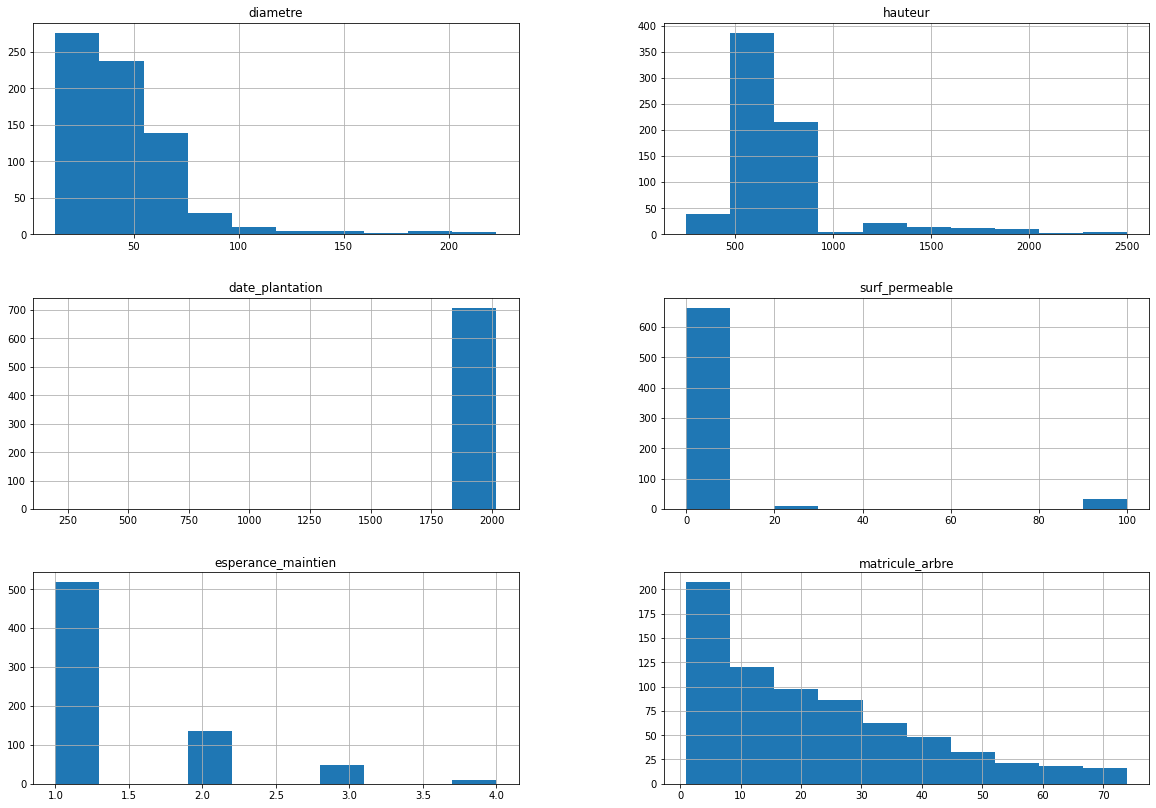

In [7]:
_ = df.hist(figsize=(20, 14))

In [8]:
cor_matrix = df.corr()
cor_matrix

,diametre,hauteur,date_plantation,surf_permeable,esperance_maintien,matricule_arbre
diametre,1.000000,0.759239,-0.155416,0.408231,0.329892,-0.109965
hauteur,0.759239,1.000000,-0.090306,0.604309,0.225723,-0.164903
date_plantation,-0.155416,-0.090306,1.000000,-0.071507,-0.033480,-0.007850
surf_permeable,0.408231,0.604309,-0.071507,1.000000,0.224826,-0.217633
esperance_maintien,0.329892,0.225723,-0.033480,0.224826,1.000000,-0.023423
matricule_arbre,-0.109965,-0.164903,-0.007850,-0.217633,-0.023423,1.000000


In [9]:
df.nunique()

quartier                    6
site                       30
cote_voirie                 2
contrainte                  2
genre_arbre                26
espece_arbre               37
situation                   4
type_sol                    9
plaie_houppier              5
bois_mort_houppier          3
classe_age                  4
ecorce_incluse_houppier     2
classe_hauteur              5
fissure_houppier            3
classe_circonference        7
port_arbre                  5
vigueur_pousse              4
champignon_collet           2
plaie_collet                7
champignon_tronc            2
fissure_tronc               3
rejet_tronc                 2
tuteurage_arbre             4
canisse_arbre               2
plaie_tronc                 6
champignon_houppier         2
diametre                   42
hauteur                    17
date_plantation            13
surf_permeable              9
esperance_maintien          4
matricule_arbre            74
label                       5
dtype: int

In [10]:
df['label'].value_counts()

C2    408
C1    237
C3     43
C4     11
C5     10
Name: label, dtype: int64

In [11]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [12]:
print(X.shape)
print(y.shape)

(709, 32)
(709,)


In [13]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [14]:
X

array([[0.0, 1.0, 0.0, ..., 5.0, 1.0, 7],
       [0.0, 1.0, 0.0, ..., 5.0, 1.0, 8],
       [0.0, 1.0, 0.0, ..., 5.0, 1.0, 9],
       ...,
       [1.0, 0.0, 0.0, ..., 1.0, 1.0, 6],
       [1.0, 0.0, 0.0, ..., 1.0, 2.0, 7],
       [1.0, 0.0, 0.0, ..., 1.0, 1.0, 8]], dtype=object)

In [15]:
le = LabelEncoder()
y = le.fit_transform(y)

In [16]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 3, 1, 2, 1, 2, 3, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 3, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [17]:
print(X.shape)
print(y.shape)

(709, 190)
(709,)


In [18]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  0 237]
 [  1 408]
 [  2  43]
 [  3  11]
 [  4  10]]


In [19]:
type(X)

numpy.ndarray

In [20]:
type(y)

numpy.ndarray

## Splitting the dataset into the Training set and Test set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Feature Scaling

In [22]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, 184:] = sc.fit_transform(X_train[:, 184:])
X_test[:, 184:]= sc.transform(X_test[:, 184:])

In [23]:
from sklearn.pipeline import make_pipeline

In [24]:
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_predict

In [25]:
%%time
max_dpt=[]
results_mde=[]
for i in range (1, 32, 2):
    log_j =[]
    for j in range (1, 6, 1):
        model_mde = GradientBoostingClassifier(loss='deviance', learning_rate= 1, 
                                               subsample= 1, n_estimators=100, max_depth=i, 
                                               max_leaf_nodes=None, random_state=j,)
        model_mde.fit(X_train, y_train)
        log_ii = log_loss(y_test, model_mde.predict_proba(X_test))
        log_j.append(log_ii)
    max_dpt.append(i)
    results_mde.append(log_j)

Wall time: 3min 49s


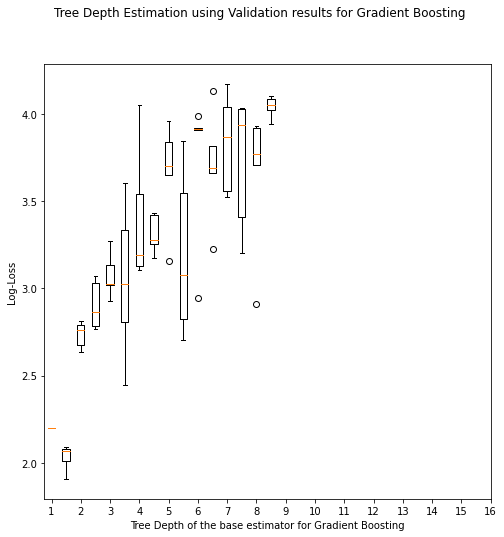

In [26]:
fig = plt.figure(figsize=(8,8))
fig.suptitle('Tree Depth Estimation using Validation results for Gradient Boosting')
plt.xlabel("Tree Depth of the base estimator for Gradient Boosting")
plt.boxplot(results_mde)
plt.ylabel("Log-Loss")
plt.xticks(max_dpt)
plt.show()